<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cross-reference-against-pathways" data-toc-modified-id="Cross-reference-against-pathways-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cross reference against pathways</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials,
                  match_all_differentials_and_tree)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp-v2'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# Load the Kang et al fecal transplant data
# week0 vs control
week0_fname = f'{kang_directory}/week0/differentials-v7.nc'
kang0_diffs = extract_differentials(week0_fname)
week0_stats = ranking(kang0_diffs, reference_percentile=80)
# week0 vs donor
donor_fname = f'{kang_directory}/donor/differentials-v7.nc'
donor_diffs = extract_differentials(donor_fname)
donor_stats = ranking(donor_diffs, reference_percentile=80)
# week 0 vs week 105
fmt_fname = f'{kang_directory}/fmt10/differentials-v7.nc'
kang_0_10_diffs = extract_differentials(fmt_fname)
week_0_10_stats = ranking(kang_0_10_diffs, reference_percentile=80)
# week 0 vs week 18
fmt_fname = f'{kang_directory}/fmt18/differentials-v7.nc'
kang_0_18_diffs = extract_differentials(fmt_fname)
week_0_18_stats = ranking(kang_0_18_diffs, reference_percentile=80)
# week 0 vs week100
fmt_fname = f'{kang_directory}/fmt100/differentials-v7.nc'
kang_0_100_diffs = extract_differentials(fmt_fname)
week_0_100_stats = ranking(kang_0_100_diffs, reference_percentile=80)

# full kang table
kang_table = biom.load_table(f'{kang_directory}/deblur/vsearch/clustered_table/feature-table.biom')
kang_md = pd.read_table(f'{kang_directory}/sample_metadata.txt', index_col=0)
kang_asd_md = kang_md.query("GROUP == 'autism' & `collection-method` == 'stool'")
kang_asd_table = (kang_table
                  .filter(lambda v, i, m: i in set(kang_asd_md.index), inplace=False)
                  .remove_empty())
# cross-sectional results
cross_sectional_diff = pd.read_csv('../results/amp_combined_diffs.csv', index_col=0)

week_0_10_stats = pd.merge(week_0_10_stats, cross_sectional_diff[['genus', 'species']], 
                            left_index=True, right_index=True)
week_0_18_stats = pd.merge(week_0_18_stats, cross_sectional_diff[['genus', 'species']], 
                            left_index=True, right_index=True)
week_0_100_stats = pd.merge(week_0_100_stats, cross_sectional_diff[['genus', 'species']], 
                            left_index=True, right_index=True)


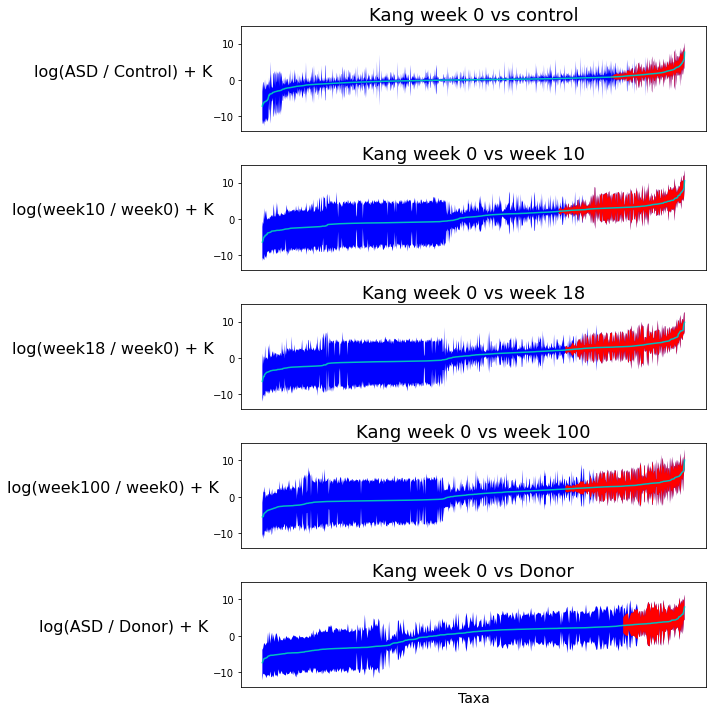

In [3]:
# Plot differentials
fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharey=True)
rankplot(week0_stats, ax[0])
ax[0].set_title('Kang week 0 vs control', fontsize=18)
ax[0].set_xticks([])
ax[0].set_ylabel('log(ASD / Control) + K', fontsize=16, 
                 rotation=0, labelpad=90)
rankplot(week_0_10_stats, ax[1])
ax[1].set_title('Kang week 0 vs week 10', fontsize=18)
ax[1].set_ylabel('log(week10 / week0) + K', fontsize=16, 
                 rotation=0, labelpad=100)
ax[1].set_xticks([])
rankplot(week_0_18_stats, ax[2])
ax[2].set_title('Kang week 0 vs week 18', fontsize=18)
ax[2].set_ylabel('log(week18 / week0) + K', fontsize=16, 
                 rotation=0, labelpad=100)
ax[2].set_xticks([])
rankplot(week_0_100_stats, ax[3])
ax[3].set_title('Kang week 0 vs week 100', fontsize=18)
ax[3].set_ylabel('log(week100 / week0) + K', fontsize=16, 
                 rotation=0, labelpad=100)
ax[3].set_xticks([])

rankplot(donor_stats, ax[4])
ax[4].set_title('Kang week 0 vs Donor', fontsize=18)
ax[4].set_xticks([])
ax[4].set_ylabel('log(ASD / Donor) + K', fontsize=16, 
                 rotation=0, labelpad=90)
ax[4].set_xlabel('Taxa', fontsize=14)
plt.tight_layout()

Pull down the CARs readout from Kang et al

In [4]:
kang_md = pd.read_excel(f'{kang_directory}/Kang_et_al_2019_metadata.xlsx', 
                        sheet_name='general data', skiprows=2)

cars = kang_md.iloc[:18, 19:26][['Baseline', 'week 10', 'week 18', '2-year']]
cars.index = kang_md.Code[:18]

cars_df = pd.melt(cars.reset_index(), id_vars=['Code'], var_name='timepoint', value_name='CARS')
time_lookup = {
    'week 10': 10,
    'week 18': 18,
    '2-year': 100,
    'Baseline': 0
}
cars_df['weeks'] = cars_df.timepoint.apply(lambda x: time_lookup[x])

Partitions subjects according to clinical severity

In [5]:
def cars_group(x):
    if x < 30:
        return 'normal'
    if x < 37:
        return 'mild'
    return 'severe'


idx = cars_df['weeks'] == 100
cars_end = cars_df.loc[idx]
cars_end['group'] = cars_end.CARS.apply(cars_group)
group = cars_end.set_index('Code')['group'].to_dict()
cars_df['group'] = cars_df.Code.apply(lambda x: group[x])

<ipython-input-5-9fb3479583a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_end['group'] = cars_end.CARS.apply(cars_group)


Aggregate differentials across time points

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='std', ylabel='Density'>

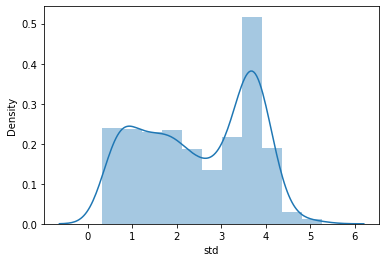

In [6]:
sns.distplot(week_0_100_stats['std'])

In [7]:
#cmd = 'std < 3 | `5%` > 0 | `95%` < 0'

cmd = 'std < 3'

all_diffs = pd.DataFrame({
    'week0_control' : week0_stats.query(cmd)['mean'],
    'week0_10' : week_0_10_stats.query(cmd)['mean'],
    'week0_18' : week_0_18_stats.query(cmd)['mean'],
    'week0_100' : week_0_100_stats.query(cmd)['mean'],
    'week0_donor' : donor_stats.query(cmd)['mean']
})
"""
all_diffs = pd.DataFrame({
    'week0_control' : week0_stats['mean'],
    'week0_10' : week_0_10_stats['mean'],
    'week0_18' : week_0_18_stats['mean'],
    'week0_100' : week_0_100_stats['mean'],
    'week0_donor' : donor_stats['mean']
})
"""

all_diffs = all_diffs.sort_values('week0_control')
all_diffs = pd.merge(all_diffs, cross_sectional_diff, left_index=True, right_index=True)

# Identify taxa that were detected to be control-associated across the majority of studies
# We need these to compute a reference frame for differential analysis
studies = ['Zurita2019', 'Zou2020', 'Fouquier2021', 'Berding2020', 'Dan2020', 'Fasano2020',
           'Chen2020']
idx1 = (cross_sectional_diff[studies] == 'neutral').mean(axis=1) > 0.99
idx2 = (cross_sectional_diff[studies] == 'denom').mean(axis=1) > 0.99

idx = set(idx1.loc[idx1].index) | set(idx2.loc[idx2].index)
idx = list(set(all_diffs.index) & idx)
control_taxa = all_diffs.loc[idx].index
control_ref = all_diffs.loc[control_taxa, ['week0_10', 'week0_18', 'week0_100']].dropna().mean(axis=0)

all_diffs = all_diffs[['week0_10', 'week0_18', 'week0_100']].dropna()
all_diffs = all_diffs - control_ref  # standardize across common reference

# cross-sectional reference frame
reference_frame = week0_stats.loc[control_taxa, 'mean'].mean()

# correcting with the reference frame from before
week_0_100_stats['5%'] -= control_ref['week0_100']
week_0_100_stats['50%'] -= control_ref['week0_100']
week_0_100_stats['95%'] -= control_ref['week0_100']
week_0_100_stats['mean'] -= control_ref['week0_100']

Visualize everything

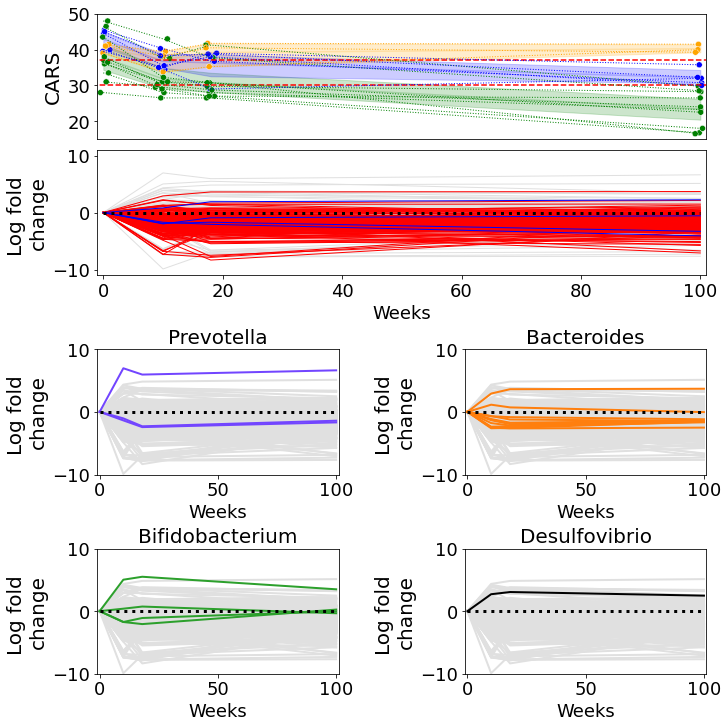

In [8]:
import matplotlib.ticker as plticker

#fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
gs = GridSpec(4, 2, figure=fig)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax21 = fig.add_subplot(gs[2, 0])
ax22 = fig.add_subplot(gs[2, 1])
ax31 = fig.add_subplot(gs[3, 0])
ax32 = fig.add_subplot(gs[3, 1])
#ax32 = fig.add_subplot(gs[3, 1])

dx = 1
fs = 20
ls = 18

# readjust differentials against week 0
col_name = 'index'
diff_data = pd.melt(all_diffs.reset_index(), id_vars=col_name, value_name='log_fold_change')
diff_data['week'] = diff_data['variable'].apply(lambda x: float(x.split('_')[1]))

# add zeros for week 0
species = diff_data[col_name].value_counts().index
dat = pd.DataFrame({col_name: species, 'variable': ['week0'] * len(species),
                    'log_fold_change': np.zeros(len(species)), 
                    'week': np.zeros(len(species))})
core_diffs = pd.concat((diff_data, dat))
core_diffs = pd.merge(core_diffs, cross_sectional_diff, 
                      left_on='index', right_index=True, how='left')

# color ASD associated vs Control associated
asd_species = set(cross_sectional_diff.query("group == 'num'").index)
con_species = set(cross_sectional_diff.query("group == 'denom'").index)
kang_asd = set(week0_stats.query(f'`5%` > {reference_frame}').index)
kang_control = set(week0_stats.query(f'`95%` < {reference_frame}').index)


def lr_f(x):
    if x in asd_species and x in kang_asd:
        return 'ASD'
    elif x in con_species and x in kang_control:
        return 'Control'
    return 'Neutral'


#core_diffs['asd_specific'] = core_diffs['species'].apply(lambda x: x in asd_species)
core_diffs['lr_group'] = core_diffs['index'].apply(lr_f)
core_diffs['group'] = core_diffs['group'].fillna('neutral')

def group_f(x):
    order = ['Prevotella', 'Enterococcus', 'Bifidobacterium', 'Desulfovibrio', 'Bacteroides']
    for o in order:
        if pd.isnull(x['species']):
            return 'Other'
        if o.split('_')[0] in x['species']:
            return o
    return 'Other'
core_diffs['groups'] = core_diffs.apply(group_f, axis=1) 

### CARS plots (top)
cars_df['rand_week'] = cars_df['weeks'] + 0.5 * np.random.randn(len(cars_df))

ax0.hlines(30, -10, 150, color='r', linestyle='--')
ax0.hlines(37, -10, 150, color='r', linestyle='--')
sns.lineplot(data=cars_df, hue='group', 
             palette={'normal': 'g', 'mild': 'blue', 'severe': 'orange'},
             x='weeks', y='CARS', alpha=0.2, ci=95,
             legend=False, ax=ax0)
sns.lineplot(data=cars_df, #hue='Code', 
             x='weeks', y='CARS', units='Code', estimator=None,
             legend=False, ax=ax0, linestyle=':', linewidth=1, 
             hue='group', palette={'normal': 'g', 'mild': 'blue', 'severe': 'orange'})
sns.scatterplot(data=cars_df, #hue='Code', 
              x='rand_week', y='CARS', 
              hue='group', palette={'normal': 'g', 'mild': 'blue', 'severe': 'orange'},
              legend=False, ax=ax0)
ax0.set_ylim([15, 50])

loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax0.yaxis.set_major_locator(loc)

ax0.set_ylabel("CARS", fontsize=fs)
ax0.tick_params(labelsize=ls, axis='y')
ax0.set_xlim([-dx, 100 + dx])
ax0.set_xticks([])
ax0.set_xlabel("")


### Microbiome differential plot (middle)
sns.lineplot(data=core_diffs,
             x='week', y='log_fold_change', units=col_name, 
             hue='lr_group', 
             hue_order=['Neutral', 'ASD', 'Control'], 
             lw=1,
             palette={'ASD': 'r', 'Neutral':'#E0E0E0', 'Control': 'b'},
             legend=False, estimator=None, ax=ax1)

ax1.set_ylim([-11, 11])
ax1.set_xlim([-dx, 100 + dx])
ax1.set_ylabel("Log fold \nchange", fontsize=fs)
ax1.tick_params(labelsize=ls, axis='x')
ax1.set_xlabel('Weeks', fontsize=ls)
ax1.tick_params(labelsize=ls, axis='y')
ax1.hlines(0, xmin=0, xmax=100, color='k', linewidth=3, linestyle=':', zorder=10)

order = ['Other', 'Bifidobacterium', 'Bacteroides', 'Prevotella', 'Desulfovibrio']
bugs = ['Prevotella', 'Bacteroides', 'Bifidobacterium', 
        'Desulfovibrio']
axes = [ax21, ax22, ax31, ax32]
palette = dict(zip(bugs, list(sns.color_palette())))
palette['Other'] = '#E0E0E0'
palette['Prevotella'] = '#7245ff'
palette['Desulfovibrio'] = 'k'
for bug, ax in zip(bugs, axes):
    idx = np.logical_or(core_diffs.groups == bug, core_diffs.groups == 'Other')
    sns.lineplot(data=core_diffs.loc[idx],
                 x='week', y='log_fold_change', units=col_name, hue='groups', 
                 hue_order=order,
                 palette=palette, linewidth=2,
                 legend=False, estimator=None, ax=ax)
    ax.set_title(bug, fontsize=fs)
    ax.set_ylim([-10, 10])
    ax.set_xlim([-dx, 100 + dx])
    ax.set_ylabel("Log fold \nchange", fontsize=fs)
    ax.tick_params(labelsize=ls, axis='y')
    ax.tick_params(labelsize=ls, axis='x')
    ax.set_xlabel('Weeks', fontsize=ls)
    ax.hlines(0, xmin=0, xmax=100, color='k', linewidth=3, 
              linestyle=':', zorder=10)
    
# plt.tight_layout()

In [9]:
core_diffs.query('variable == "week0_100"')['lr_group'].value_counts()

ASD        236
Neutral    154
Control      4
Name: lr_group, dtype: int64

In [10]:
decreased_taxa = list(core_diffs
                      .query('variable == "week0_100"')
                      .query('log_fold_change < 0')['index'].values)
cross_sectional_asd_specific = list(core_diffs
                                    .query('variable == "week0"')
                                    #.query('group == "num"')['index']
                                    .query('lr_group == "ASD"')['index']
                                    .values)
kang_taxa = list(kang_asd_table.ids(axis='observation'))

cross_sectional_asd_specific = set(cross_sectional_asd_specific) & set(kang_taxa)

In [11]:
len(set(decreased_taxa) & set(cross_sectional_asd_specific)) / len(cross_sectional_asd_specific)

0.9152542372881356

In [12]:
sig_decreased_taxa = list(week_0_100_stats
                          .query('`95%` < 0').index)
print(len(set(decreased_taxa) & set(cross_sectional_asd_specific) & set(sig_decreased_taxa))
      / len(set(decreased_taxa) & set(cross_sectional_asd_specific)))

0.5740740740740741


In [13]:
len(decreased_taxa), len(sig_decreased_taxa), len(cross_sectional_asd_specific)

(339, 261, 236)

In [14]:
len(set(decreased_taxa) & set(sig_decreased_taxa))

173

In [15]:
print(len(set(decreased_taxa) & set(sig_decreased_taxa))
      / len(set(decreased_taxa)))

0.5103244837758112


In [16]:
len(set(kang_taxa) - set(decreased_taxa)) / len(kang_taxa)

0.6623505976095617

In [17]:
print(
    'Total Prevotella', len(week_0_100_stats.query('genus == "Prevotella"')),
    'Increased', np.sum(week_0_100_stats.query('genus == "Prevotella"')['5%'] > 0),
    'Decreased', np.sum(week_0_100_stats.query('genus == "Prevotella"')['95%'] < 0)
)

Total Prevotella 13 Increased 1 Decreased 0


In [18]:
print(
    'Total Bifidobacterium', len(week_0_100_stats.query('genus == "Bifidobacterium"')),
    'Increased', np.sum(week_0_100_stats.query('genus == "Bifidobacterium"')['5%'] > 0),
    'Decreased', np.sum(week_0_100_stats.query('genus == "Bifidobacterium"')['95%'] < 0)
)

Total Bifidobacterium 6 Increased 0 Decreased 0


In [19]:
print(
    'Total Desulfovibrio', len(week_0_100_stats.query('genus == "Desulfovibrio_R"')),
    'Increased', np.sum(week_0_100_stats.query('genus == "Desulfovibrio_R"')['5%'] > 0),
    'Decreased', np.sum(week_0_100_stats.query('genus == "Desulfovibrio_R"')['95%'] < 0)
)

Total Desulfovibrio 5 Increased 1 Decreased 1


In [20]:
print(
    'Total Bacteroides', len(week_0_100_stats.query('genus == "Bacteroides_E"')),
    'Total Stable Bacteroides', len(week_0_100_stats.query('genus == "Bacteroides_E"').query('std < 3')),
    'Increased', np.sum(week_0_100_stats.query('genus == "Bacteroides_E"')['5%'] > 0),
    'Decreased', np.sum(week_0_100_stats.query('genus == "Bacteroides_E"')['95%'] < 0)
)

Total Bacteroides 20 Total Stable Bacteroides 10 Increased 1 Decreased 8


In [21]:
week_0_100_stats.query('genus == "Prevotella"').query('`5%`<0 & `95%`>0').query('std<3')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
AB547677,-1.414973,1.263114,-3.525494,-1.432670,0.787309,1.293743,0.626779,0.973797,3.307475e-01,Prevotella,Prevotella corporis
AB547706,-0.582857,1.624411,-3.356690,-0.472545,1.757562,1.097592,0.378973,11.002345,9.058331e-25,Prevotella,Prevotella timonensis
MJ006-2-barcode62-umi152501bins-ubs-3,-1.681763,2.900740,-5.993926,-1.728009,2.999374,0.213604,0.118845,-1.415425,1.577241e-01,Prevotella,Prevotella copri


In [22]:
week_0_100_stats.query('genus == "Desulfovibrio_R"').query('`5%`<0 & `95%`>0').query('std<3')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
G000420465,-2.276469,2.485095,-6.317894,-2.302108,2.057562,0.194734,0.161925,-6.438345,3.473432e-10,Desulfovibrio_R,Desulfovibrio_R desulfuricans_A


In [23]:
week_0_100_stats.query('genus == "Bifidobacterium"').query('`5%`<0 & `95%`>0').query('std<3')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
GU361825,3.489157,2.902222,-2.071696,3.741778,7.601722,0.827298,0.118724,34.219519,9.505012e-121,Bifidobacterium,Bifidobacterium merycicum
KF990498,-0.025251,0.814636,-1.350872,-0.066532,1.279367,5.204450,1.506861,35.628769,5.068984e-126,Bifidobacterium,Bifidobacterium faecale
KU298954,0.248991,1.897776,-2.762056,0.161204,3.541654,1.035130,0.277658,18.184076,2.973195e-54,Bifidobacterium,Bifidobacterium callitrichidarum
U25952,-0.335661,1.520221,-3.205850,-0.368060,2.050707,1.360159,0.432700,15.008515,1.096283e-40,Bifidobacterium,Bifidobacterium bifidum


In [24]:
week_0_100_stats.query('genus == "Bacteroides_E"').query('`5%`<0 & `95%`>0').query('std<3')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
AB510710,-1.409337,0.827887,-2.702529,-1.449454,0.088006,3.019786,1.459010,1.621896,1.056155e-01,Bacteroides_E,Bacteroides_E thetaiotaomicron
G000598965,-1.183292,1.226178,-3.162557,-1.161277,0.901439,1.526955,0.665110,4.782042,2.445370e-06,Bacteroides_E,Bacteroides_E fragilis
MJ006-1-barcode39-umi113359bins-ubs-4,-1.556978,2.762509,-6.237651,-1.371943,2.442367,0.251866,0.131037,-0.582836,5.603332e-01,Bacteroides_E,Bacteroides_E cellulosilyticus
MJ006-2-barcode74-umi167704bins-ubs-3,-0.428416,2.870471,-4.862081,-0.434737,3.704590,0.370245,0.121365,7.302343,1.547162e-12,Bacteroides_E,NaN
MJ009-1-barcode40-umi125366bins-ubs-3,-1.521778,1.061551,-3.197046,-1.479335,0.240785,1.736910,0.887398,-0.853541,3.938715e-01,Bacteroides_E,Bacteroides_E stercoris
MJ009-2-barcode72-umi122833bins-ubs-3,-0.040685,1.561674,-2.743919,-0.063415,2.560658,1.409859,0.410033,18.387818,3.893389e-55,Bacteroides_E,Bacteroides_E nordii


Let's investigate the log fold changes after 100 weeks using the full posterior distribution

In [25]:
week_0_100_stats.query('`5%` > 0')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
AB214328,3.690028,1.037565,1.970116,3.680752,5.345628,6.659403,0.928902,99.589026,6.311075e-284,Bacteroides_E,Bacteroides_E intestinalis
G004803695,3.178408,1.091938,1.555118,3.146050,4.971744,5.583608,0.838695,85.259102,3.246725e-258,Muribaculum,Muribaculum sp002492595
G900539795,6.626991,1.717045,4.020878,6.517598,9.559139,3.427830,0.339185,94.388505,5.201459e-275,Prevotella,Prevotella sp003447235
HM037997,1.993328,1.180807,0.181052,1.907798,4.057807,3.924833,0.717203,58.770011,1.425330e-198,Sutterella,Sutterella wadsworthensis_A
MJ006-1-barcode35-umi143487bins-ubs-3,5.115629,1.333779,3.134620,4.994944,7.354422,4.831294,0.562124,98.848477,1.104608e-282,CAG-83,NaN
MJ006-2-barcode61-umi150937bins-ubs-3,2.476545,1.294188,0.617287,2.459417,4.750260,3.555763,0.597042,61.088776,1.310968e-204,Desulfovibrio_R,Desulfovibrio_R piger_A
MJ006-2-barcode73-umi141562bins-ubs-3,3.387679,1.717687,1.094911,3.202934,6.404066,2.327364,0.338932,56.636093,7.558244e-193,Coprobacter,Coprobacter secundus
MJ010-1-barcode41-umi160418bins-ubs-3,3.261373,1.120744,1.506582,3.195881,5.103175,5.366317,0.796135,84.548220,7.698665e-257,Parabacteroides_B,Parabacteroides_B goldsteinii


In [26]:
week_0_100_stats.query('`95%` < 0')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
AB222699,-8.220193,3.342021,-13.653365,-8.357334,-2.304225,-0.424484,0.089533,-40.357136,6.243401e-143,Bacteroides_E,Bacteroides_E finegoldii
AB266102,-1.299845,0.768885,-2.490743,-1.346567,-0.005593,3.686228,1.691520,4.594404,5.829195e-06,Adlercreutzia,Adlercreutzia equolifaciens
AB510711,-1.670472,0.547115,-2.476290,-1.694348,-0.745355,6.042099,3.340735,-7.091683,6.068994e-12,Bacteroides_E,Bacteroides_E uniformis
AB547651,-8.875643,2.563207,-13.687381,-8.556282,-5.055961,-0.821390,0.152206,-57.733673,8.188997e-196,Paraprevotella,Paraprevotella clara
AB548672,-6.141620,3.093966,-11.909240,-5.894104,-1.590096,-0.278140,0.104465,-30.156410,6.073737e-105,Clostridioides_A,Clostridioides_A difficile
...,...,...,...,...,...,...,...,...,...,...,...
MJ030-2-barcode73-umi92216bins-ubs-4,-1.905286,0.450517,-2.644048,-1.910018,-1.177022,7.754023,4.926942,-19.036423,5.959364e-58,Lawsonibacter,Lawsonibacter sp000492175
MJ032-1-barcode44-umi68943bins-ubs-3,-5.819649,3.538541,-11.950073,-5.510703,-0.845066,-0.186927,0.079864,-24.547830,9.262430e-82,NaN,NaN
X85101,-1.759398,0.398040,-2.406518,-1.741877,-1.179031,10.854154,6.311701,-14.215875,2.144225e-37,Blautia_A,Blautia_A obeum
X96961,-7.134048,2.916527,-12.442250,-6.875054,-2.769416,-0.429686,0.117562,-38.796645,1.755158e-137,Eubacterium_O,Eubacterium_O callanderi


In [27]:
week_0_100_stats.query('`95%` > 0 & `5%` < 0').query('std < 3')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
AB242142,-1.120728,1.707143,-3.564483,-1.285765,1.888458,0.809226,0.343131,4.167728,3.775022e-05,Phocaeicola,Phocaeicola dorei
AB443949,-1.305004,1.571105,-3.723969,-1.245916,1.010485,0.880776,0.405125,2.182791,2.963348e-02,Butyricimonas,Butyricimonas virosa
AB470343,-0.660310,2.605161,-4.328004,-0.632229,3.312356,0.415328,0.147344,6.265745,9.624219e-10,Parabacteroides_B,Parabacteroides_B gordonii
AB510710,-1.409337,0.827887,-2.702529,-1.449454,0.088006,3.019786,1.459010,1.621896,1.056155e-01,Bacteroides_E,Bacteroides_E thetaiotaomicron
AB547677,-1.414973,1.263114,-3.525494,-1.432670,0.787309,1.293743,0.626779,0.973797,3.307475e-01,Prevotella,Prevotella corporis
...,...,...,...,...,...,...,...,...,...,...,...
MJ032-1-barcode44-umi36862bins-ubs-10,1.877840,2.665377,-2.158697,1.830516,6.373370,0.754047,0.140761,25.169533,2.133766e-84,Ruminiclostridium_E,NaN
U25952,-0.335661,1.520221,-3.205850,-0.368060,2.050707,1.360159,0.432700,15.008515,1.096283e-40,Bifidobacterium,Bifidobacterium bifidum
X72865,-0.360848,1.020490,-1.883552,-0.424911,1.258376,2.994273,0.960245,21.864508,3.105476e-70,Phascolarctobacterium_A,Phascolarctobacterium_A faecium
X94967,-0.866296,1.001376,-2.480513,-0.887711,0.784036,2.605612,0.997253,12.186785,2.919339e-29,Ruminococcus_B,Ruminococcus_B gnavus


In [28]:
week_0_100_stats.query('species == "Roseburia inulinivorans"')

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,genus,species
G003457795,-1.79127,0.852622,-3.159703,-1.783476,-0.348169,2.321731,1.375583,-7.384189,9.025953e-13,Roseburia,Roseburia inulinivorans


In [29]:
decreased_taxa = list(week_0_100_stats
                      .query('`95%` < 0').index)
cross_sectional_asd_specific = list(core_diffs
                                    .query('variable == "week0"')
                                    #.query('group == "num"')['index']
                                    .query('lr_group == "ASD"')['index']
                                    .values)
kang_taxa = list(kang_asd_table.ids(axis='observation'))

cross_sectional_asd_specific = set(cross_sectional_asd_specific) & set(kang_taxa)

In [30]:
len(set(decreased_taxa) & set(cross_sectional_asd_specific)) / len(cross_sectional_asd_specific)

0.5254237288135594

In [31]:
len(set(kang_taxa) - set(decreased_taxa)) / len(kang_taxa)

0.7400398406374502

# Cross reference against pathways

In [70]:
sig_wgs = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
ko_ogu = get_genomic_data(f'{wgs_directory}/ogus3-func.biom')

# cross-reference against taxonomy
#taxa = pd.read_table('~/ceph/wol2/wol2/taxonomy/ranks.tsv', index_col=0)
#taxid_map = pd.read_table('~/ceph/wol2/wol2/taxonomy/taxid.map', index_col=0, header=None, dtype='str')
#taxid_map.columns = ['genome']
#taxonomy = pd.merge(taxid_map, taxa, left_index=True, right_index=True)
#ko_ogu = pd.merge(ko_ogu, taxonomy['genome'], left_index=True, right_on='genome').iloc[:, :-1]

In [71]:
sig_pwys = sig_wgs.drop_duplicates(subset=['Pathway', 'KO'])
sig_pwys = sig_pwys.query("`class` == 'ASD-associated'")
decreased_kos = ko_ogu.reindex(decreased_taxa).dropna().sum(axis=0)
decreased_kos = decreased_kos.loc[decreased_kos > 0]
decreased_kos.name = 'num_observed'

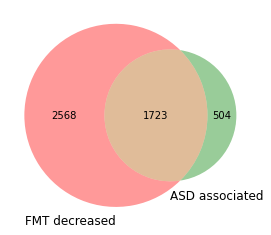

In [72]:
# Venn diagram to visualize overlap
venn2([set(decreased_kos.index), 
       set(sig_pwys['KO'])], 
      set_labels=['FMT decreased', 'ASD associated'])

In [56]:
#common_kos = set(decreased_kos.index) & set(sig_pwys['KO'].values)#
#sig_pwys.set_index('KO').loc[common_kos]
sig_pwys = pd.merge(sig_pwys, decreased_kos, left_on='KO', right_index=True, how='inner')
sig_pwys = sig_pwys.sort_values(['Name', 'num_observed'])
common_pwys = sig_pwys.query('num_observed >= 10')

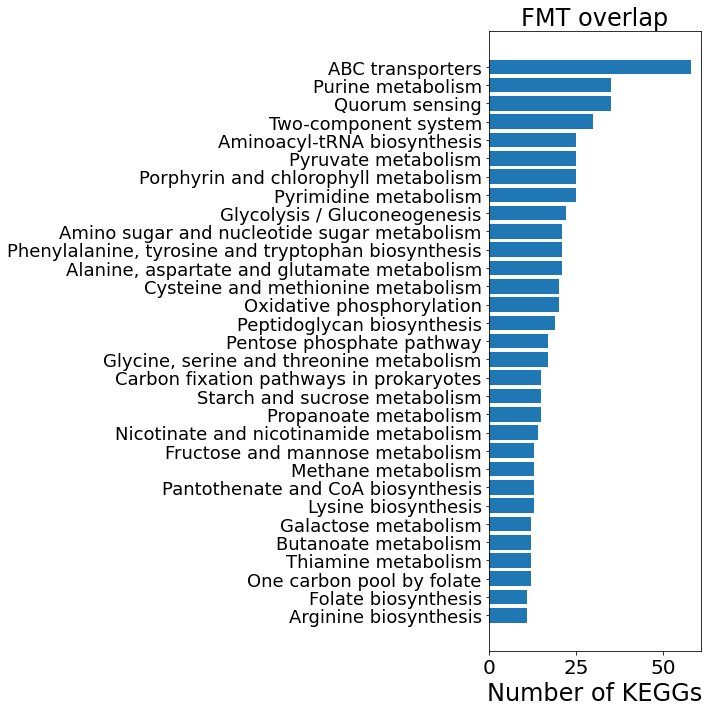

In [78]:
# Visualize KEGG counts for shotgun metagenomics data
fig, ax = plt.subplots(figsize=(10, 10))
pwy_counts = common_pwys['Name']
pwy_counts = pwy_counts.value_counts()
pwy_counts = pwy_counts.sort_values(ascending=True)
# only focus on highly representive pathways
pwy_counts = pwy_counts.loc[pwy_counts > 10] 
ax.barh(pwy_counts.index, pwy_counts.values)
ax.set_xlabel('Number of KEGGs', fontsize=24)
ax.tick_params(axis='y', which='major', labelsize=18)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.set_title('FMT overlap', fontsize=24)

plt.tight_layout()

In [ ]:
decreased_taxa

In [ ]:
kang_kos = ko_ogu.reindex(kang_taxa).dropna().sum(axis=0)
kang_kos = kang_kos.loc[kang_kos > 0]

In [ ]:
len(sig_asd_kos) / len(kang_kos)

In [ ]:
sig_asd_kos = sig_wgs.query("`class` == 'ASD-associated'")['KO'].unique()

In [ ]:
len(sig_asd_kos)

In [ ]:
pd.merge(ko_ogu, taxonomy['genome'], left_index=True, right_on='genome')

In [ ]:
ko_ogu

In [ ]:
all_lfc = core_diffs.reset_index()
all_lfc.pop('level_0')
all_lfc.pop('effect_size')
all_lfc.pop('effect_std')
all_lfc.pop('perc_shap')
all_lfc.pop('shap_mean')
all_lfc.pop('importance')
all_lfc.pop('group_logodds')
all_lfc.to_csv('../results/supplemental_tables/Table_S16.csv')

In [ ]:
core_diffs['index']